In [776]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [777]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys

sys.path.append("../utils")
from utils import *
from data_retrieve import *
from gbm import *

In [778]:
last_id = 287
backtest_start = 187
backtest_end = 252
h = 0.01

In [779]:
combined_df.iloc[backtest_start], combined_df.iloc[backtest_end]

(Date               2024-07-25 00:00:00
 ROG_Last_Price                   277.5
 ROG_IVOL                       18.2666
 CFR_Last_Price                   131.2
 CFR_IVOL                        23.415
 ZURN_Last_Price                  474.6
 ZURN_IVOL                      14.5858
 Risk_Free_Rate                  0.8649
 Name: 187, dtype: object,
 Date               2024-10-25 00:00:00
 ROG_Last_Price                   279.6
 ROG_IVOL                           NaN
 CFR_Last_Price                  128.05
 CFR_IVOL                           NaN
 ZURN_Last_Price                  521.2
 ZURN_IVOL                          NaN
 Risk_Free_Rate                     NaN
 Name: 252, dtype: object)

In [780]:
tickers = ["ROG_Last_Price", "CFR_Last_Price", "ZURN_Last_Price"]

# Getting Delta and gammas

In [781]:
prices = []
prices_up = {}
prices_down = {}
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    prices_up[t] = []
    prices_down[t] = []


h = 0.01
n_paths = 100
drift = 0.01107  # overwrriten by GBMTS
risk_neutral = False
implied_volatility = True
drifts = []
for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers, drift = MultivariateGBMSimulationTS(
        s0=close.iloc[current_id],
        n_paths=n_paths,
        current_id=current_id,
        window_size=30,
        implied_volatility=implied_volatility,
        h=h,
    )
    drift = np.array(drift)
    drifts.append(drift[0] / 100)
    # result, tickers = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, drift=drift, window_size=30, implied_volatility=implied_volatility, h=h)

    old_path = {}
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        old_path[t] = combined_df[t].iloc[:current_id]
        payoff_up[t] = []
        payoff_down[t] = []
    path_rog = [[], [], []]
    path_cfr = [[], [], []]
    path_zurn = [[], [], []]
    for i in range(result.shape[-2]):
        path_rog[0].append(np.append(old_path[tickers[0]], result[0][0][i].flatten()))
        path_cfr[0].append(np.append(old_path[tickers[1]], result[0][1][i].flatten()))
        path_zurn[0].append(np.append(old_path[tickers[2]], result[0][2][i].flatten()))

        path_rog[1].append(np.append(old_path[tickers[0]], result[1][0][i].flatten()))
        path_cfr[1].append(np.append(old_path[tickers[1]], result[1][1][i].flatten()))
        path_zurn[1].append(np.append(old_path[tickers[2]], result[1][2][i].flatten()))

        path_rog[2].append(np.append(old_path[tickers[0]], result[2][0][i].flatten()))
        path_cfr[2].append(np.append(old_path[tickers[1]], result[2][1][i].flatten()))
        path_zurn[2].append(np.append(old_path[tickers[2]], result[2][2][i].flatten()))

    payoff = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )

    up = payoff_func_parallel(
        path_rog[1],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[2],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["ROG_Last_Price"] = up
    payoff_down["ROG_Last_Price"] = down

    up = payoff_func_parallel(
        path_rog[0],
        path_cfr[1],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[0],
        path_cfr[2],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["CFR_Last_Price"] = up
    payoff_down["CFR_Last_Price"] = down
    up = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[1],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[2],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["ZURN_Last_Price"] = up
    payoff_down["ZURN_Last_Price"] = down

    for t in tickers:
        prices_up[t].append(np.mean(payoff_up[t]))
        prices_down[t].append(np.mean(payoff_down[t]))
    prices.append(np.mean(payoff))

prices = np.array(prices)

for t in tickers:
    prices_up[t] = np.array(prices_up[t])
    prices_down[t] = np.array(prices_down[t])

for t in tickers:
    deltas[t].append(
        np.exp(-np.mean(drifts) * (last_id - current_id))
        * (prices_up[t] - prices_down[t])
        / (2 * h)
    )
    gammas[t].append(
        np.exp(-np.mean(drifts) * (last_id - current_id))
        * (prices_up[t] - prices * 2 + prices_down[t])
        / (h * h)
    )

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

## AV GREEKS CELL

In [ ]:
prices = []
prices_up = {}
prices_down = {}
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    prices_up[t] = []
    prices_down[t] = []


h = 0.01
n_paths = 10000
drift = 0.01107  # overwrriten by GBMTS
risk_neutral = True
implied_volatility = True

# drifts = []
for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers = MultivariateGBMSimulationAV(
        s0=close.iloc[current_id],
        n_paths=n_paths,
        current_id=current_id,
        window_size=30,
        implied_volatility=implied_volatility,
        h=h,
    )
    # drifts.append(drift[0] / 100)
    # result, tickers = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, drift=drift, window_size=30, implied_volatility=implied_volatility, h=h)

    old_path = {}
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        old_path[t] = combined_df[t].iloc[:current_id]
        payoff_up[t] = []
        payoff_down[t] = []
    path_rog = [[], [], []]
    path_cfr = [[], [], []]
    path_zurn = [[], [], []]
    for i in range(result.shape[-2]):
        path_rog[0].append(np.append(old_path[tickers[0]], result[0][0][i].flatten()))
        path_cfr[0].append(np.append(old_path[tickers[1]], result[0][1][i].flatten()))
        path_zurn[0].append(np.append(old_path[tickers[2]], result[0][2][i].flatten()))

        path_rog[1].append(np.append(old_path[tickers[0]], result[1][0][i].flatten()))
        path_cfr[1].append(np.append(old_path[tickers[1]], result[1][1][i].flatten()))
        path_zurn[1].append(np.append(old_path[tickers[2]], result[1][2][i].flatten()))

        path_rog[2].append(np.append(old_path[tickers[0]], result[2][0][i].flatten()))
        path_cfr[2].append(np.append(old_path[tickers[1]], result[2][1][i].flatten()))
        path_zurn[2].append(np.append(old_path[tickers[2]], result[2][2][i].flatten()))

    payoff = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )

    up = payoff_func_parallel(
        path_rog[1],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[2],
        path_cfr[0],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["ROG_Last_Price"] = up
    payoff_down["ROG_Last_Price"] = down

    up = payoff_func_parallel(
        path_rog[0],
        path_cfr[1],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[0],
        path_cfr[2],
        path_zurn[0],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["CFR_Last_Price"] = up
    payoff_down["CFR_Last_Price"] = down
    up = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[1],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    down = payoff_func_parallel(
        path_rog[0],
        path_cfr[0],
        path_zurn[2],
        combined_df.iloc[current_id]["Date"],
        risk_free=drift,
        risk_neutral=risk_neutral,
        verbose=False,
    )
    payoff_up["ZURN_Last_Price"] = up
    payoff_down["ZURN_Last_Price"] = down

    for t in tickers:
        prices_up[t].append(np.mean(payoff_up[t]))
        prices_down[t].append(np.mean(payoff_down[t]))
    prices.append(np.mean(payoff))

prices = np.array(prices)

for t in tickers:
    prices_up[t] = np.array(prices_up[t])
    prices_down[t] = np.array(prices_down[t])

for t in tickers:
    deltas[t].append(
        np.exp(-drift * (last_id - current_id))
        * (prices_up[t] - prices_down[t])
        / (2 * h)
    )
    gammas[t].append(
        np.exp(-drift * (last_id - current_id))
        * (prices_up[t] - prices * 2 + prices_down[t])
        / (h * h)
    )

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

{'ROG_Last_Price': [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 'CFR_Last_Price': [array([ 1.44188477,  1.4670207 ,  1.22273814,  0.        ,  0.        ,
          0.08037712,  6.69206293,  4.13371542,  1.39376138,  5.1055901 ,
          0.08076224,  2.68985597,  0.        ,  0.08478671,  1.32239264,
          1.36402408,  0.03873278,  0.04006417,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  2.66051851,  1.34695737,  0.        ,
          0.        ,  2.65951872,  1.45954851,  0.1118077 ,  5.49766088,
         14.88317934,  5.40892874,  0.04036052,  0.        ,  0.        ,

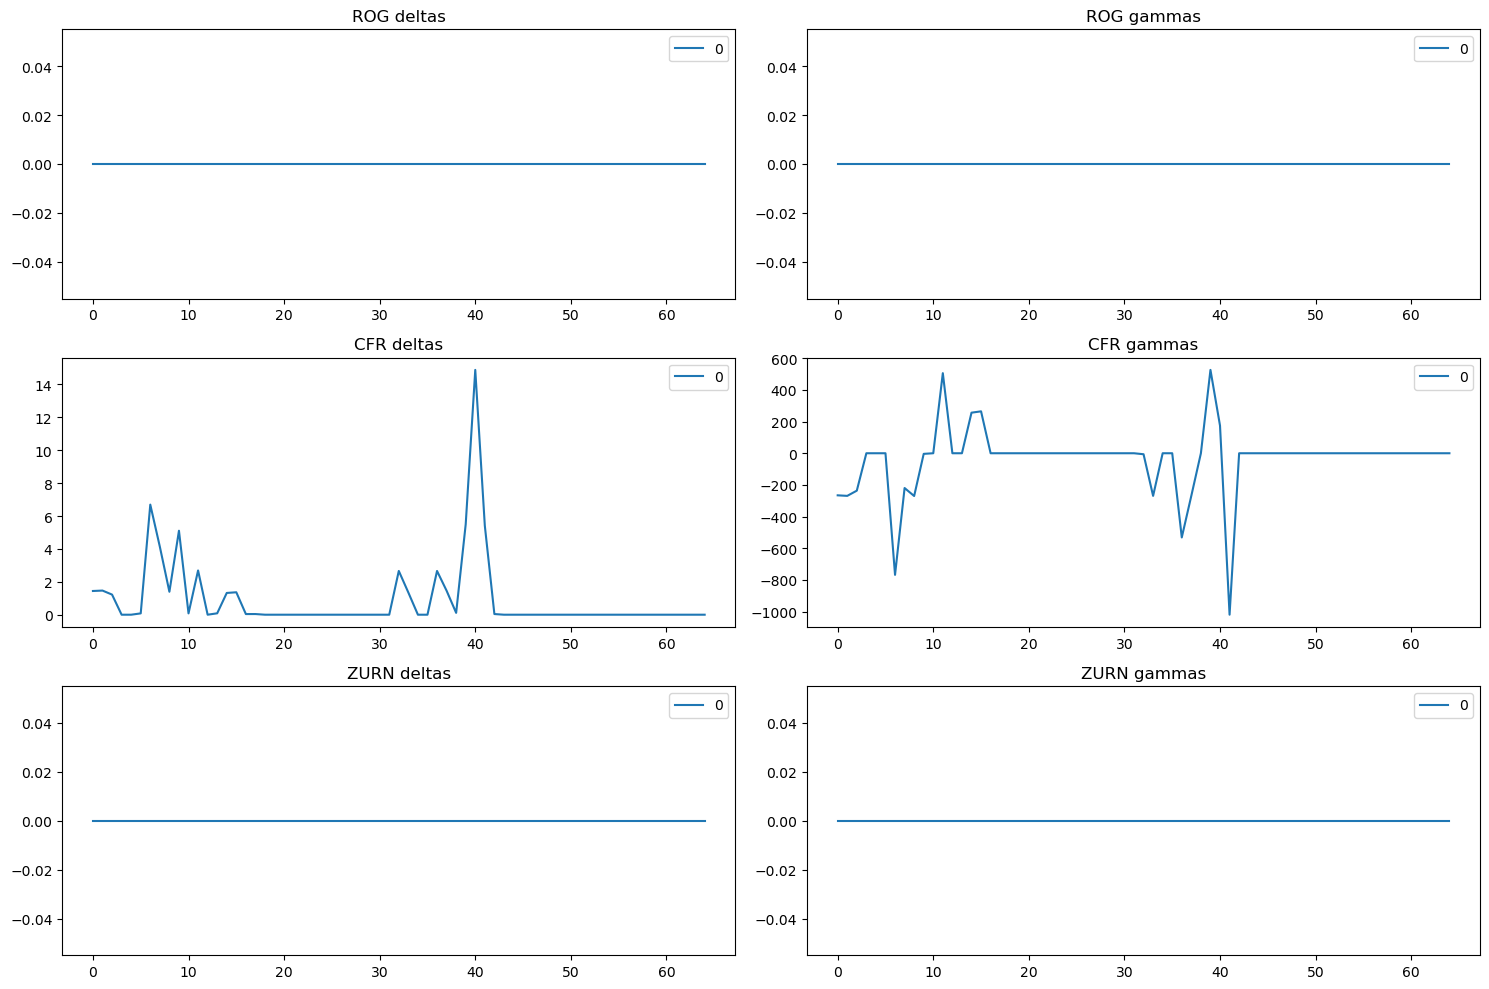

In [788]:
labels = ["ROG", "CFR", "ZURN"]
f, axes = plt.subplots(3, 2, figsize=(15, 10))
for i, t in enumerate(tickers):
    sns.lineplot(deltas[t], ax=axes[i][0])
    axes[i][0].set_title(f"{labels[i]} deltas")
    sns.lineplot(gammas[t], ax=axes[i][1])
    axes[i][1].set_title(f"{labels[i]} gammas")

plt.tight_layout()

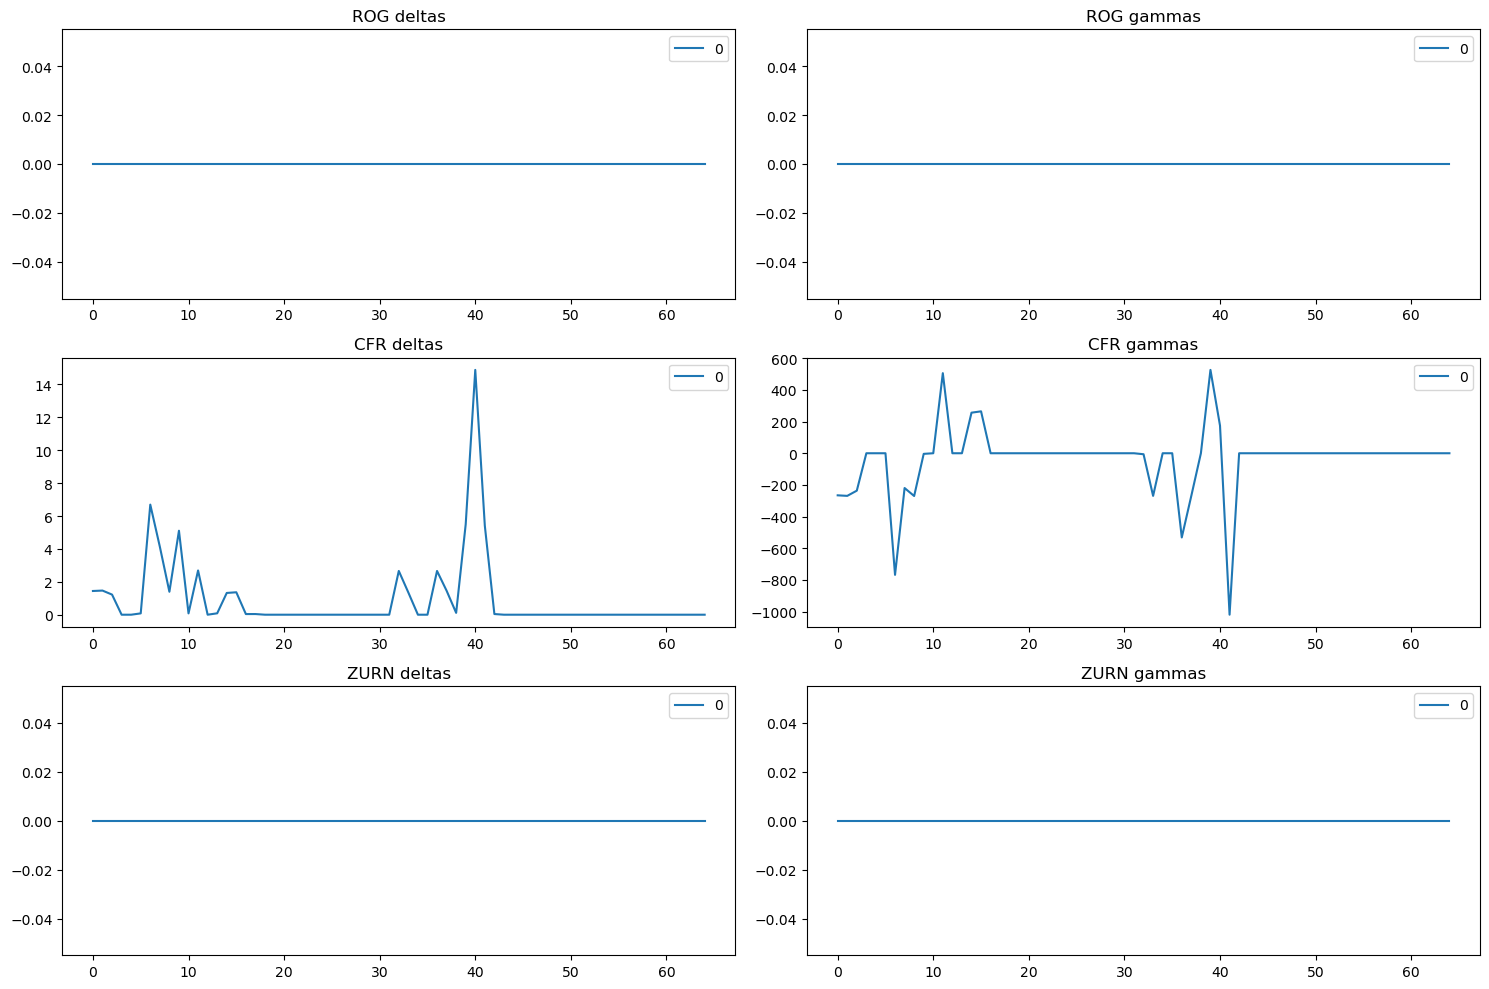

In [784]:
labels = ["ROG", "CFR", "ZURN"]
f, axes = plt.subplots(3, 2, figsize=(15, 10))
for i, t in enumerate(tickers):
    sns.lineplot(deltas[t], ax=axes[i][0])
    axes[i][0].set_title(f"{labels[i]} deltas")
    sns.lineplot(gammas[t], ax=axes[i][1])
    axes[i][1].set_title(f"{labels[i]} gammas")

plt.tight_layout()

In [789]:
price_1 = [prices]

/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


1188.9192639996186


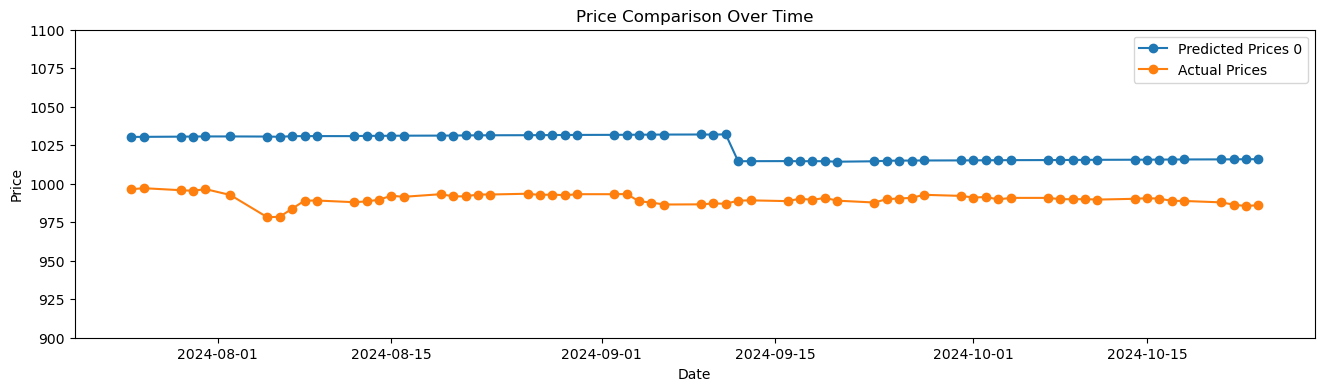

In [792]:
combined_df = retrieve_data()

evaluation_plot(backtest_start, backtest_end, combined_df, price_1, ylim=(900, 1100))